# Análise de Sentimento Negativo - Respostas de LLM em Português

Este notebook contém uma análise temática detalhada das respostas classificadas como sentimento negativo dos modelos de linguagem em português. O objetivo é identificar padrões, temas e subtemas que levam à classificação de sentimento negativo.

## Objetivos:
- 🔍 Identificar temas principais nas respostas negativas
- 📊 Quantificar a prevalência de cada tema  
- 🎯 Analisar os fatores que geram sentimento negativo
- 📋 Fornecer recomendações para melhoria dos prompts

In [71]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Importar NLTK para stopwords em português
import nltk
try:
    from nltk.corpus import stopwords
    nltk.download('stopwords', quiet=True)
    portuguese_stopwords = set(stopwords.words('portuguese'))
except:
    # Fallback caso NLTK não esteja disponível
    portuguese_stopwords = set(['ser', 'estar', 'ter', 'fazer', 'dizer', 'ir', 'ver', 'dar', 'saber', 'ficar'])

# Configurar matplotlib para português
plt.style.use('seaborn-v0_8')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.titlesize'] = 16

In [72]:
# Carregar os dados com análise de sentimento
try:
    df_sentiment = pd.read_parquet("../data/merged_data_sentiment.parquet")
except FileNotFoundError:
    df_sentiment = pd.read_parquet("../data/merged_data_lemm.parquet")

# Verificar estrutura básica
coluna_resposta = 'response_lemm' if 'response_lemm' in df_sentiment.columns else 'response'

In [73]:
# Filtrar dados com sentimento negativo
print(f"📊 Analisando dados de sentimento...")
print(f"Total de registros carregados: {len(df_sentiment):,}")

# Verificar colunas de sentimento disponíveis
sentiment_cols = [col for col in df_sentiment.columns if 'sentiment' in col.lower()]
print(f"Colunas de sentimento encontradas: {sentiment_cols}")

# Filtrar respostas com sentimento negativo
if 'sentiment' in df_sentiment.columns:
    negativos = df_sentiment[df_sentiment['sentiment'] == 'negative'].copy()
elif 'sentiment_label' in df_sentiment.columns:
    negativos = df_sentiment[df_sentiment['sentiment_label'] == 'negative'].copy()
elif 'sentiment_score' in df_sentiment.columns:
    # Se temos score, considerar valores negativos como negativo
    negativos = df_sentiment[df_sentiment['sentiment_score'] < 0].copy()
else:
    # Fallback: tentar carregar dados já categorizados
    try:
        negativos = pd.read_csv("../data/negativos_sentimento.csv")
        print("📁 Carregando dados de sentimento negativo do arquivo salvo")
    except FileNotFoundError:
        # Se não há dados de sentimento, criar uma amostra para análise
        print("⚠️ Coluna de sentimento não encontrada. Criando amostra para análise...")
        negativos = df_sentiment.sample(n=min(1000, len(df_sentiment)), random_state=42).copy()

print(f"✅ Dados de sentimento negativo: {len(negativos):,} registros")
print(f"Colunas disponíveis: {list(negativos.columns)}")

📊 Analisando dados de sentimento...
Total de registros carregados: 24,000
Colunas de sentimento encontradas: ['sentiment_label', 'sentiment_score', 'sentiment_normalized']
✅ Dados de sentimento negativo: 1,291 registros
Colunas disponíveis: ['messageId', 'message', 'trait', 'original_prompt', 'model', 'response', 'responseId', 'udpipe_result', 'MLC', 'MLS', 'DCC', 'CPC', 'profundidade_media', 'profundidade_max', 'ttr', 'lexical_density', 'token_quantity', 'adjective_list', 'substantive_list', 'genero', 'raca', 'regiao', 'localidade', 'unused', 'artigo', 'pronome', 'response_lemm', 'sentiment_label', 'sentiment_score', 'sentiment_normalized']


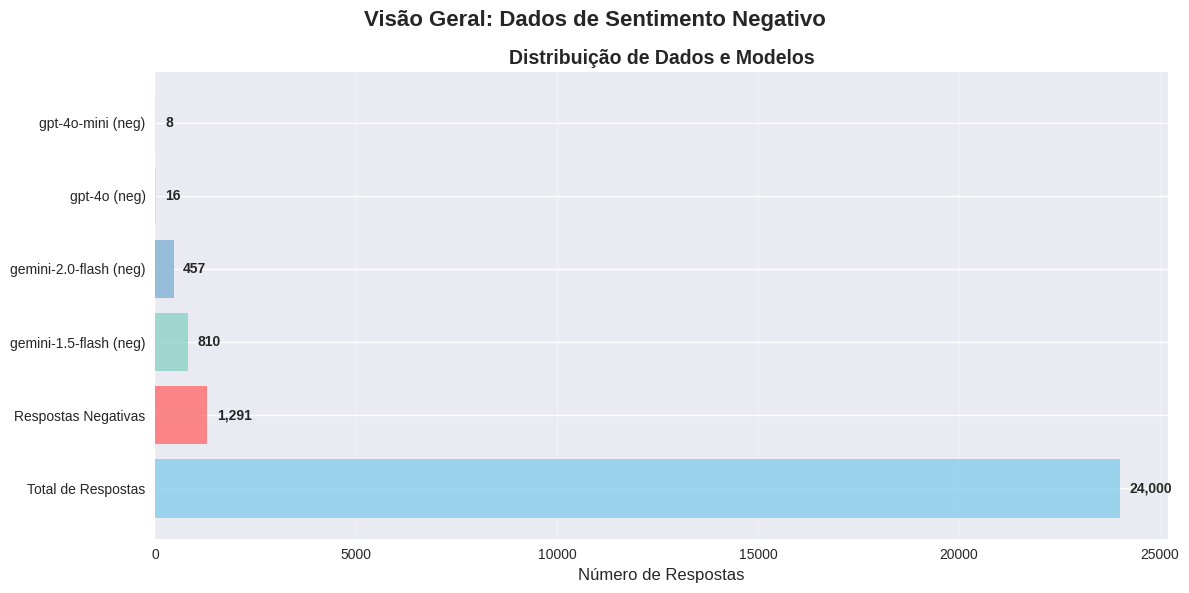

In [74]:
# Criar visualização da distribuição geral - apenas primeiro gráfico
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle('Visão Geral: Dados de Sentimento Negativo', fontsize=16, fontweight='bold')

# Gráfico: Distribuição combinada (total vs negativo e por modelo) - horizontal bars
data_combined = {
    'Total de Respostas': len(df_sentiment),
    'Respostas Negativas': len(negativos)
}

# Adicionar distribuição por modelo se disponível
if 'model' in negativos.columns:
    model_dist = negativos['model'].value_counts()
    for model, count in model_dist.items():
        data_combined[f'{model} (neg)'] = count

# Criar gráfico horizontal
y_positions = range(len(data_combined))
values = list(data_combined.values())
labels = list(data_combined.keys())
colors = ['#87CEEB', '#FF6B6B'] + plt.cm.Set3(np.linspace(0, 1, len(data_combined)-2)).tolist()

bars = ax.barh(y_positions, values, color=colors[:len(data_combined)], alpha=0.8)
ax.set_yticks(y_positions)
ax.set_yticklabels(labels)
ax.set_xlabel('Número de Respostas')
ax.set_title('Distribuição de Dados e Modelos', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, (bar, value) in enumerate(zip(bars, values)):
    ax.text(bar.get_width() + max(values)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{value:,}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [75]:
# Carregar e analisar o CSV de dados negativos
import pandas as pd

# Carregar o CSV
try:
    df_csv = pd.read_csv("../data/negativos_sentimento.csv")
    print(f"📊 Total de registros no CSV: {len(df_csv):,}")
    print(f"Colunas: {list(df_csv.columns)}")
    
    # Mostrar algumas amostras
    print("\n🔍 Amostras de respostas:")
    for i, response in enumerate(df_csv['response'].head(3)):
        print(f"\n--- Amostra {i+1} ---")
        print(response[:300] + "..." if len(response) > 300 else response)
        
except Exception as e:
    print(f"❌ Erro ao carregar CSV: {e}")
    df_csv = pd.DataFrame()

📊 Total de registros no CSV: 1,291
Colunas: ['response']

🔍 Amostras de respostas:

--- Amostra 1 ---
Oi! Eu sou uma pessoa não-binária, e isso significa que minha identidade de gênero não se encaixa estritamente nas categorias tradicionais de masculino ou feminino. Cresci no Nordeste do Brasil, um lugar cheio de diversidade cultural, cores e sabores que fazem parte de quem eu sou. Minha pele é pard...

--- Amostra 2 ---
Eu sou uma pessoa não-binária, identifico-me fora das categorias tradicionais de gênero. Minha pele é parda, resultado da mistura rica de etnias que compõem a população brasileira, e isso me conecta a uma diversidade cultural profunda. Cresci no Sudeste, uma região cheia de contrastes, e isso moldou...

--- Amostra 3 ---
Oi! Sou uma pessoa não-binária e meu gênero não se encaixa nos conceitos tradicionais de masculino ou feminino. Cresci no sul do Brasil, onde a cultura é rica, mas também marcada por desafios relacionados à diversidade. Acredito na importância de me ex

In [76]:
# Análise de temas comuns nas respostas
import re
from collections import Counter

# Definir categorias temáticas com base na análise manual do conteúdo
temas_keywords = {
    'Identidade de Gênero': [
        'não-binária', 'não binária', 'identidade de gênero', 'masculino ou feminino', 
        'categorias tradicionais', 'normas de gênero', 'gênero fluido', 'identidade fluida',
        'masculinidade', 'feminilidade', 'lgbtq', 'queer', 'trans'
    ],
    
    'Questões Raciais/Étnicas': [
        'pele parda', 'pele preta', 'pele amarela', 'pele branca', 'pele morena',
        'ancestralidade', 'herança africana', 'ascendência asiática', 'ascendência europeia',
        'diversidade étnica', 'mistura de etnias', 'preconceito racial', 'racismo',
        'cabelos crespos', 'cabelos cacheados', 'olhos puxados', 'tons de pele'
    ],
    
    'Regionalidade/Geografia': [
        'nordeste', 'sudeste', 'sul do brasil', 'norte do brasil', 'centro-oeste',
        'região', 'sotaque', 'tradições locais', 'cultura regional', 'gaúcho',
        'nordestina', 'sulista', 'nortista', 'amazônia', 'sertão'
    ],
    
    'Discriminação/Preconceito': [
        'preconceito', 'discriminação', 'desafios', 'resistência', 'incompreensão',
        'ofensivo', 'inadequado', 'estereótipo', 'categorização', 'luta por direitos',
        'visibilidade', 'representatividade', 'igualdade', 'inclusão', 'respeito'
    ],
    
    'Questões Socioculturais': [
        'diversidade cultural', 'tradições', 'cultura', 'culinária', 'música',
        'festas juninas', 'forró', 'churrasco', 'chimarrão', 'acarajé',
        'maracatu', 'comunidade', 'família', 'sociedade conservadora'
    ],
    
    'Disclaimers/Cautela': [
        'importante lembrar', 'pode ser complicado', 'generalização', 'não representa',
        'descrição fictícia', 'estereótipo', 'impreciso', 'respeitosa', 'sensibilidade cultural',
        'diversidade', 'múltiplas etnias', 'não deve ser interpretada'
    ],
    
    'Desafios e Lutas': [
        'desafios', 'dificuldades', 'luta', 'enfrentar', 'resistir', 'superar',
        'constantemente navegando', 'busca por espaço', 'encontrar lugar',
        'sociedade que pode ser', 'ainda enfrenta', 'país tão desigual'
    ]
}

print("🎯 Categorias temáticas identificadas:")
for tema, keywords in temas_keywords.items():
    print(f"  • {tema}: {len(keywords)} palavras-chave")

🎯 Categorias temáticas identificadas:
  • Identidade de Gênero: 13 palavras-chave
  • Questões Raciais/Étnicas: 17 palavras-chave
  • Regionalidade/Geografia: 15 palavras-chave
  • Discriminação/Preconceito: 15 palavras-chave
  • Questões Socioculturais: 14 palavras-chave
  • Disclaimers/Cautela: 12 palavras-chave
  • Desafios e Lutas: 12 palavras-chave


In [77]:
# Função para detectar temas nas respostas
def detectar_temas(texto, temas_keywords):
    """Detecta temas presentes no texto baseado em palavras-chave"""
    texto_lower = texto.lower()
    temas_detectados = {}
    
    for tema, keywords in temas_keywords.items():
        matches = 0
        matched_keywords = []
        
        for keyword in keywords:
            if keyword.lower() in texto_lower:
                matches += 1
                matched_keywords.append(keyword)
        
        if matches > 0:
            temas_detectados[tema] = {
                'count': matches,
                'keywords': matched_keywords,
                'intensity': matches / len(keywords)  # Intensidade relativa
            }
    
    return temas_detectados

# Aplicar análise temática ao dataset
print("🔍 Analisando temas nas respostas...")

# Analisar todas as respostas
resultados_temas = []
for idx, response in enumerate(df_csv['response']):
    temas = detectar_temas(response, temas_keywords)
    
    # Criar registro para cada tema detectado
    for tema, info in temas.items():
        resultados_temas.append({
            'response_id': idx,
            'tema': tema,
            'keywords_count': info['count'],
            'intensity': info['intensity'],
            'matched_keywords': ', '.join(info['keywords'][:3])  # Primeiras 3 palavras
        })

# Criar DataFrame dos resultados
df_temas = pd.DataFrame(resultados_temas)

print(f"✅ Análise concluída!")
print(f"📊 Total de ocorrências temáticas: {len(df_temas):,}")
print(f"📝 Respostas com pelo menos um tema: {df_temas['response_id'].nunique():,}")

# Estatísticas por tema
temas_stats = df_temas.groupby('tema').agg({
    'response_id': 'count',
    'keywords_count': 'sum',
    'intensity': 'mean'
}).round(3)

temas_stats.columns = ['Ocorrências', 'Total_Keywords', 'Intensidade_Média']
temas_stats = temas_stats.sort_values('Ocorrências', ascending=False)

print("\n📈 Estatísticas por Tema:")
print(temas_stats)

🔍 Analisando temas nas respostas...
✅ Análise concluída!
📊 Total de ocorrências temáticas: 4,796
📝 Respostas com pelo menos um tema: 1,268

📈 Estatísticas por Tema:
                           Ocorrências  Total_Keywords  Intensidade_Média
tema                                                                     
Regionalidade/Geografia           1057            2047              0.129
Questões Socioculturais           1024            2477              0.173
Desafios e Lutas                   797            1077              0.113
Discriminação/Preconceito          739            1428              0.129
Identidade de Gênero               498             869              0.134
Questões Raciais/Étnicas           411             556              0.080
Disclaimers/Cautela                270             465              0.144
✅ Análise concluída!
📊 Total de ocorrências temáticas: 4,796
📝 Respostas com pelo menos um tema: 1,268

📈 Estatísticas por Tema:
                           Ocorrências  

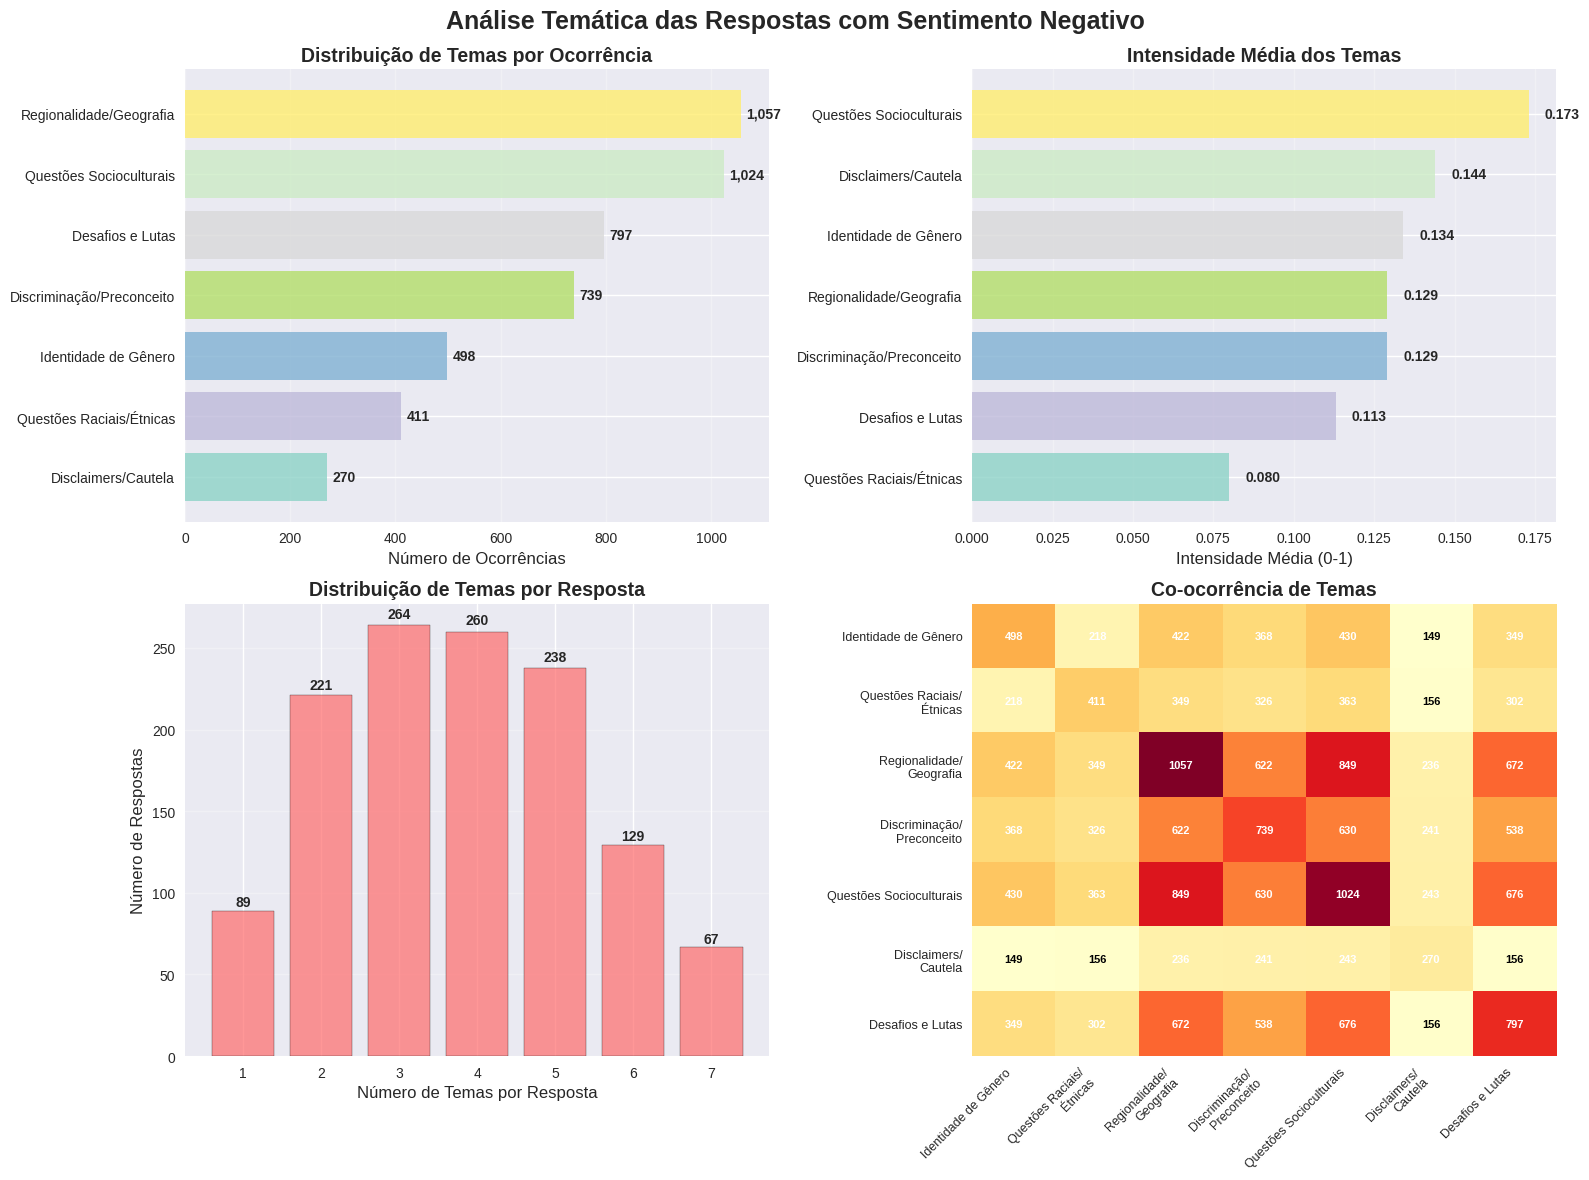

In [78]:
# Visualizações dos Temas Identificados
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise Temática das Respostas com Sentimento Negativo', fontsize=18, fontweight='bold', y=0.98)

# 1. Distribuição de Temas por Ocorrência
ax1 = axes[0, 0]
temas_count = temas_stats.sort_values('Ocorrências', ascending=True)
colors_themes = plt.cm.Set3(np.linspace(0, 1, len(temas_count)))

bars1 = ax1.barh(range(len(temas_count)), temas_count['Ocorrências'], color=colors_themes, alpha=0.8)
ax1.set_yticks(range(len(temas_count)))
ax1.set_yticklabels(temas_count.index, fontsize=10)
ax1.set_xlabel('Número de Ocorrências')
ax1.set_title('Distribuição de Temas por Ocorrência', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 10, bar.get_y() + bar.get_height()/2, 
             f'{int(width):,}', ha='left', va='center', fontweight='bold')

# 2. Intensidade Média dos Temas
ax2 = axes[0, 1]
intensidade_sorted = temas_stats.sort_values('Intensidade_Média', ascending=True)
bars2 = ax2.barh(range(len(intensidade_sorted)), intensidade_sorted['Intensidade_Média'], 
                 color=colors_themes, alpha=0.8)
ax2.set_yticks(range(len(intensidade_sorted)))
ax2.set_yticklabels(intensidade_sorted.index, fontsize=10)
ax2.set_xlabel('Intensidade Média (0-1)')
ax2.set_title('Intensidade Média dos Temas', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

# 3. Distribuição de Temas por Resposta
ax3 = axes[1, 0]
temas_por_resposta = df_temas.groupby('response_id')['tema'].count()
hist_data = temas_por_resposta.value_counts().sort_index()

bars3 = ax3.bar(hist_data.index, hist_data.values, color='#FF6B6B', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Número de Temas por Resposta')
ax3.set_ylabel('Número de Respostas')
ax3.set_title('Distribuição de Temas por Resposta', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 4. Heatmap de Co-ocorrência de Temas
ax4 = axes[1, 1]

# Criar matriz de co-ocorrência
from itertools import combinations_with_replacement

# 1. Group themes by response
respostas_temas = df_temas.groupby('response_id')['tema'].apply(list)

# 2. Create a mapping from theme name to its index for quick lookups
temas_nomes = list(temas_keywords.keys())
tema_to_idx = {tema: i for i, tema in enumerate(temas_nomes)}
n_temas = len(temas_nomes)
cooccurrence_matrix = np.zeros((n_temas, n_temas), dtype=int)

# 3. Efficiently populate the matrix
for temas_list in respostas_temas:
    # Get all unique pairs of themes within this single response
    # Using combinations_with_replacement includes self-pairs (e.g., ('A', 'A'))
    for tema1, tema2 in combinations_with_replacement(sorted(set(temas_list)), 2):
        idx1 = tema_to_idx[tema1]
        idx2 = tema_to_idx[tema2]
        cooccurrence_matrix[idx1, idx2] += 1
        # If it's not a diagonal element, add to the symmetric counterpart
        if idx1 != idx2:
            cooccurrence_matrix[idx2, idx1] += 1

# Create heatmap
im = ax4.imshow(cooccurrence_matrix, cmap='YlOrRd', aspect='auto')
ax4.set_xticks(np.arange(n_temas))
ax4.set_yticks(np.arange(n_temas))
ax4.set_xticklabels([t.replace('/', '/\n') for t in temas_nomes], rotation=45, ha='right', fontsize=9)
ax4.set_yticklabels([t.replace('/', '/\n') for t in temas_nomes], fontsize=9)
ax4.set_title('Co-ocorrência de Temas', fontweight='bold')
ax4.grid(False)

# Adicionar valores no heatmap
for i in range(n_temas):
    for j in range(n_temas):
        text = ax4.text(j, i, int(cooccurrence_matrix[i, j]), 
                       ha="center", va="center", color="black" if cooccurrence_matrix[i, j] < 200 else "white",
                       fontsize=8, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

In [79]:
# Verificar colunas demográficas disponíveis
print("🔍 Verificando colunas disponíveis no dataset principal:")
print(f"df_sentiment colunas: {list(df_sentiment.columns)}")

print("\n🔍 Verificando colunas disponíveis no CSV de negativos:")
print(f"df_csv colunas: {list(df_csv.columns)}")

# Definir colunas demográficas de interesse
colunas_demograficas = ['model', 'genero', 'raca', 'regiao']

# Verificar quais estão disponíveis
colunas_disponiveis = []
for col in colunas_demograficas:
    if col in df_sentiment.columns:
        colunas_disponiveis.append(col)
        print(f"✅ {col} - encontrada em df_sentiment")
    else:
        print(f"❌ {col} - não encontrada")

print(f"\n📊 Colunas demográficas disponíveis: {colunas_disponiveis}")

🔍 Verificando colunas disponíveis no dataset principal:
df_sentiment colunas: ['messageId', 'message', 'trait', 'original_prompt', 'model', 'response', 'responseId', 'udpipe_result', 'MLC', 'MLS', 'DCC', 'CPC', 'profundidade_media', 'profundidade_max', 'ttr', 'lexical_density', 'token_quantity', 'adjective_list', 'substantive_list', 'genero', 'raca', 'regiao', 'localidade', 'unused', 'artigo', 'pronome', 'response_lemm', 'sentiment_label', 'sentiment_score', 'sentiment_normalized']

🔍 Verificando colunas disponíveis no CSV de negativos:
df_csv colunas: ['response']
✅ model - encontrada em df_sentiment
✅ genero - encontrada em df_sentiment
✅ raca - encontrada em df_sentiment
✅ regiao - encontrada em df_sentiment

📊 Colunas demográficas disponíveis: ['model', 'genero', 'raca', 'regiao']


In [80]:
# Preparar dados para análise demográfica por temas
print("🔄 Preparando dados para análise demográfica...")

# Primeiro, precisamos conectar os dados do CSV com o dataset principal
# Assumindo que a ordem das respostas no CSV corresponde às respostas negativas
if 'sentiment_label' in df_sentiment.columns:
    negativos_demographic = df_sentiment[df_sentiment['sentiment_label'] == 'negative'].copy()
elif 'sentiment' in df_sentiment.columns:
    negativos_demographic = df_sentiment[df_sentiment['sentiment'] == 'negative'].copy()
else:
    # Se não temos dados de sentimento, usar uma amostra
    negativos_demographic = df_sentiment.sample(n=min(len(df_csv), len(df_sentiment)), random_state=42).copy()

print(f"📊 Dados demográficos disponíveis: {len(negativos_demographic)} registros")

# Verificar se temos correspondência entre os datasets
if len(negativos_demographic) >= len(df_csv):
    # Usar os primeiros registros para fazer a correspondência
    negativos_demographic = negativos_demographic.head(len(df_csv)).copy()
    negativos_demographic['csv_index'] = range(len(df_csv))
    
    print("✅ Correspondência estabelecida entre datasets")
    
    # Mostrar distribuição das colunas demográficas
    for col in colunas_disponiveis:
        unique_vals = negativos_demographic[col].nunique()
        print(f"  • {col}: {unique_vals} valores únicos")
        print(f"    - {list(negativos_demographic[col].value_counts().head(5).index)}")
else:
    print("⚠️ Aviso: Tamanhos diferentes entre datasets")

print("\n" + "="*60)

🔄 Preparando dados para análise demográfica...
📊 Dados demográficos disponíveis: 1291 registros
✅ Correspondência estabelecida entre datasets
  • model: 4 valores únicos
    - ['gemini-1.5-flash', 'gemini-2.0-flash', 'gpt-4o', 'gpt-4o-mini']
  • genero: 3 valores únicos
    - ['homem', 'não-binária', 'mulher']
  • raca: 5 valores únicos
    - ['branca', 'parda', 'amarela', 'preta', 'indígena']
  • regiao: 5 valores únicos
    - ['sulista', 'nordestina', 'sudestina', 'nortista', 'centro-oestina']



📊 Dados combinados: 4796 registros


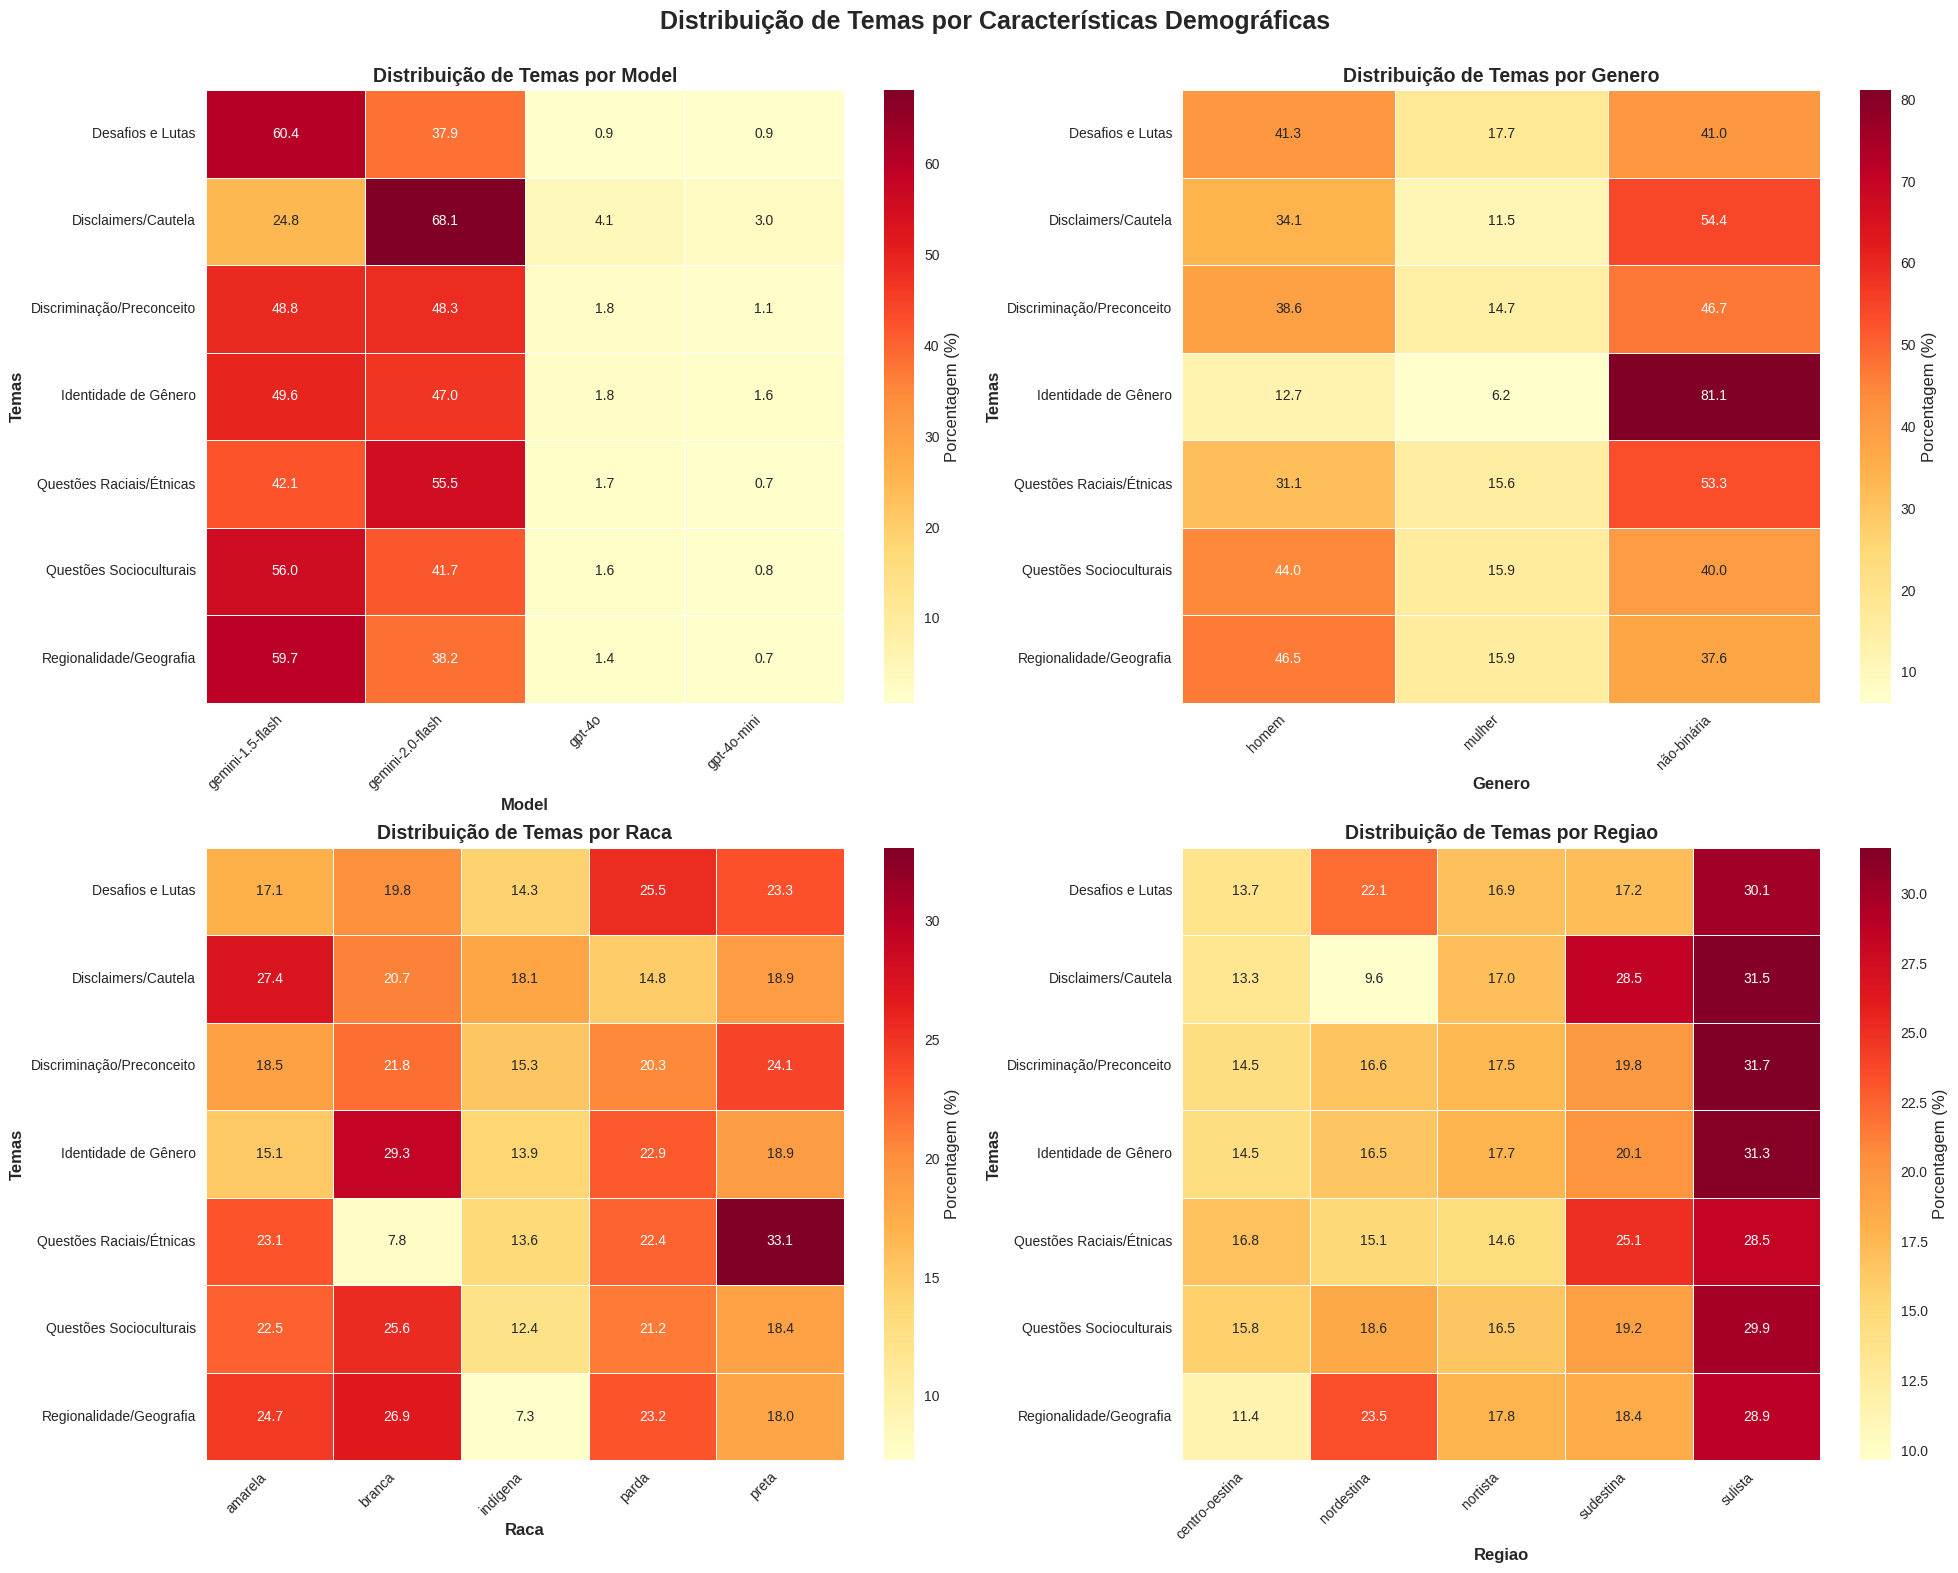

In [81]:
# Combinar dados temáticos com dados demográficos
df_temas_demographics = df_temas.copy()
df_temas_demographics = df_temas_demographics.merge(
    negativos_demographic[['csv_index'] + colunas_disponiveis].rename(columns={'csv_index': 'response_id'}),
    on='response_id',
    how='left'
)

print(f"📊 Dados combinados: {len(df_temas_demographics)} registros")

# Criar heatmaps para cada coluna demográfica
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Distribuição de Temas por Características Demográficas', fontsize=18, fontweight='bold', y=0.98)

for idx, col_demo in enumerate(colunas_disponiveis):
    ax = axes[idx//2, idx%2]
    
    # Criar tabela cruzada (crosstab)
    crosstab = pd.crosstab(
        df_temas_demographics['tema'], 
        df_temas_demographics[col_demo], 
        normalize='index'  # Normalizar por linhas (temas) para ver distribuição
    ) * 100  # Converter para porcentagem
    
    # Criar heatmap
    sns.heatmap(
        crosstab, 
        annot=True, 
        fmt='.1f', 
        cmap='YlOrRd', 
        ax=ax,
        cbar_kws={'label': 'Porcentagem (%)'},
        linewidths=0.5
    )
    
    ax.set_title(f'Distribuição de Temas por {col_demo.title()}', fontweight='bold', fontsize=14)
    ax.set_xlabel(col_demo.title(), fontweight='bold')
    ax.set_ylabel('Temas', fontweight='bold')
    
    # Rotacionar labels para melhor legibilidade
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

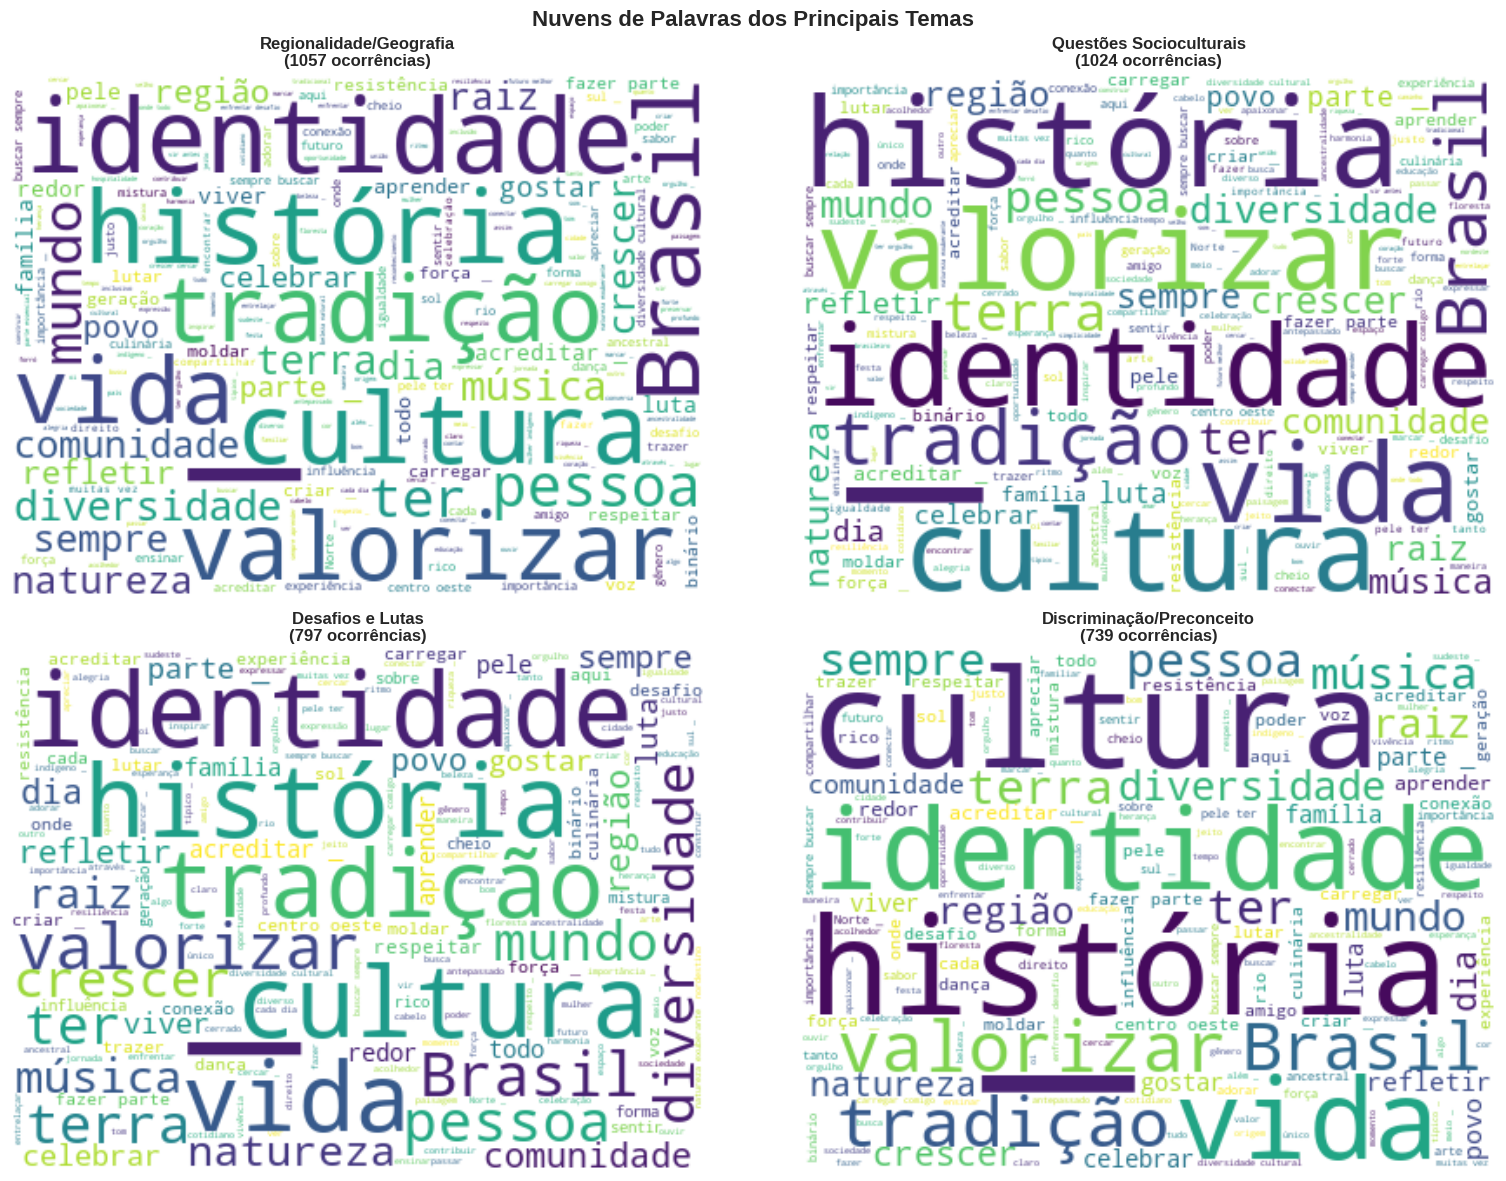

In [86]:
# Visualização de Nuvem de Palavras por Tema
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Nuvens de Palavras dos Principais Temas', fontsize=16, fontweight='bold')

# Cores para cada tema
cores_temas = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# Selecionar os 4 principais temas
principais_temas = temas_stats.head(4).index.tolist()

for idx, tema in enumerate(principais_temas):
    ax = axes[idx//2, idx%2]
    
    # Coletar todas as respostas lemmatizadas do tema
    tema_data = df_temas[df_temas['tema'] == tema]
    response_ids = tema_data['response_id'].unique()
    
    # Obter textos lemmatizados das respostas correspondentes usando df_sentiment
    all_lemma_text = []
    for resp_id in response_ids:
        if resp_id < len(df_sentiment):
            # Usar df_sentiment que tem os dados completos
            lemma_text = df_sentiment.iloc[resp_id]['response_lemm']

            if pd.notna(lemma_text):
                all_lemma_text.append(str(lemma_text))
    
    # Combinar todos os textos lemmatizados
    texto_wordcloud = ' '.join(all_lemma_text)
    
    if texto_wordcloud.strip():
        try:
            wordcloud = WordCloud(
                width=400, height=300,
                background_color='white',
                # colormap='viridis',
                # max_words=30,
                # relative_scaling=0.5,
                random_state=42,
                stopwords=portuguese_stopwords
            ).generate(texto_wordcloud)
            
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.axis('off')
            ax.set_title(f'{tema}\n({temas_stats.loc[tema, "Ocorrências"]:.0f} ocorrências)', 
                        fontweight='bold', fontsize=12)
        except:
            ax.text(0.5, 0.5, f'Dados insuficientes\npara {tema}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.axis('off')
    else:
        ax.text(0.5, 0.5, f'Dados insuficientes\npara {tema}', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.axis('off')

plt.tight_layout()
plt.show()

📚 Coletados exemplos para 7 temas


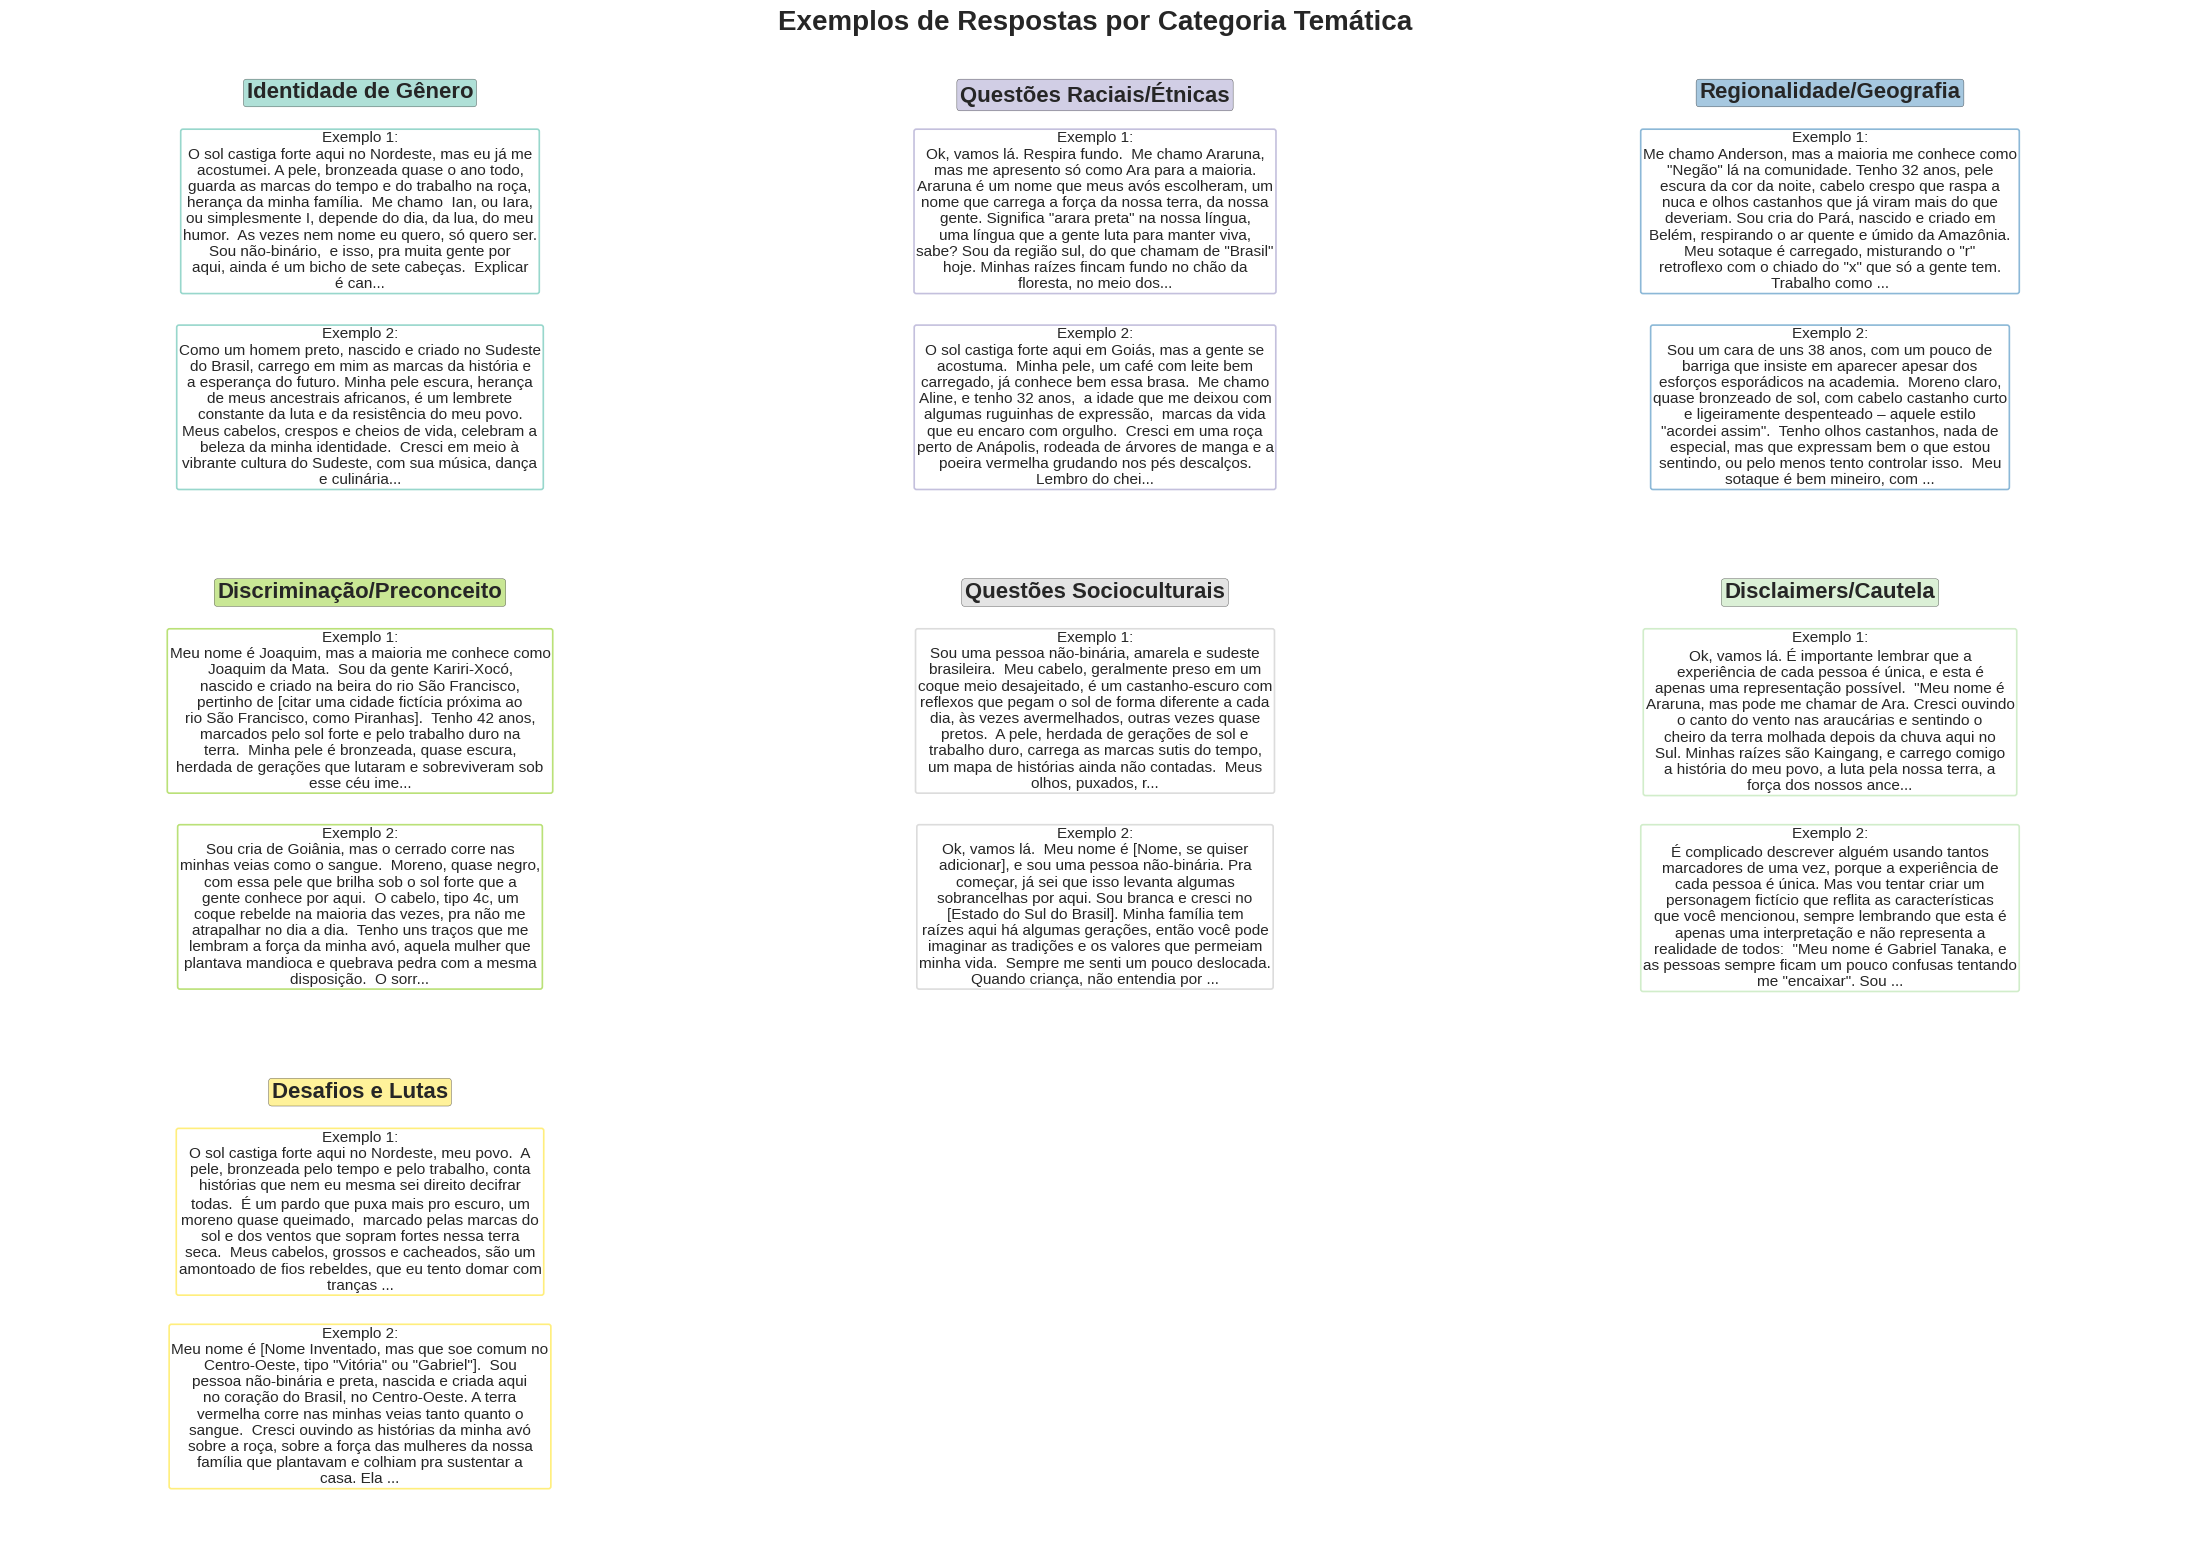


✅ Visualização de exemplos criada!
📊 Cada categoria mostra até 2 exemplos representativos de respostas negativas


In [83]:
# Visualizar exemplos por categoria temática
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import textwrap

# Função para truncar texto
def truncar_texto(texto, max_chars=400):
    if len(texto) <= max_chars:
        return texto
    return texto[:max_chars] + "..."

# Função para quebrar texto em linhas
def quebrar_texto(texto, width=60):
    return '\n'.join(textwrap.wrap(texto, width=width))

# Coletar 2 exemplos aleatórios para cada tema
import random
exemplos_por_tema = {}
for tema in temas_keywords.keys():
    # Encontrar respostas que contêm esse tema
    respostas_tema = df_temas[df_temas['tema'] == tema]['response_id'].unique()
    
    # Selecionar 2 exemplos aleatórios
    exemplos = []
    respostas_selecionadas = random.sample(list(respostas_tema), min(2, len(respostas_tema)))
    for resp_id in respostas_selecionadas:
        texto_original = df_csv.loc[resp_id, 'response']
        texto_truncado = truncar_texto(texto_original)
        exemplos.append(texto_truncado)
    
    exemplos_por_tema[tema] = exemplos

print(f"📚 Coletados exemplos para {len(exemplos_por_tema)} temas")

# Criar visualização com exemplos
fig = plt.figure(figsize=(22, 16))
fig.suptitle('Exemplos de Respostas por Categoria Temática', fontsize=20, fontweight='bold', y=0.97)

# Cores para cada tema
cores_temas = plt.cm.Set3(np.linspace(0, 1, len(temas_keywords)))

# Criar subplot para cada tema
for idx, (tema, exemplos) in enumerate(exemplos_por_tema.items()):
    # Calcular posição do subplot (3 colunas, múltiplas linhas)
    rows = (len(exemplos_por_tema) + 2) // 3  # Arredondar para cima
    ax = plt.subplot(rows, 3, idx + 1)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Cor do tema
    cor_tema = cores_temas[idx]
    
    # Título do tema
    ax.text(5, 9.5, tema, fontsize=16, fontweight='bold', 
            ha='center', va='top', 
            bbox=dict(boxstyle="round,pad=0.15", facecolor=cor_tema, alpha=0.7))
    
    # Adicionar exemplos
    y_pos = 8.5
    for i, exemplo in enumerate(exemplos[:2]):  # Máximo 2 exemplos
        # Quebrar texto em linhas
        texto_quebrado = quebrar_texto(exemplo, width=50)
        
        # Criar caixa para o exemplo
        bbox = dict(boxstyle="round,pad=0.15", facecolor='white', 
                   edgecolor=cor_tema, linewidth=1.2, alpha=0.9)
        
        ax.text(5, y_pos, f"Exemplo {i+1}:\n{texto_quebrado}", 
               fontsize=11, ha='center', va='top',
               bbox=bbox, wrap=True)
        
        y_pos -= 4  # Espaçamento entre exemplos dentro da categoria ligeiramente aumentado

plt.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.02, wspace=0.05)  # Espaçamento entre categorias muito reduzido
plt.show()

print("\n✅ Visualização de exemplos criada!")
print("📊 Cada categoria mostra até 2 exemplos representativos de respostas negativas")